## Compare ACCESS-OM2-01 and ACCESS-OM2-025 for one year of output

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram


In [2]:
client = Client(n_workers=8)
client

<Client: 'tcp://127.0.0.1:37893' processes=8 threads=16, memory=250.00 GiB>

In [3]:
# files:
base = '/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/';
xch = 1440#2*288
ych = 1080#2*216

fgrd   = xr.open_dataset(base + 'output096/ocean/ocean_grid.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch,'xu_ocean':xch})
fwmass_mean = xr.open_mfdataset('/scratch/e14/cy8964/temp/025deg_096/ocean_wmass_mean.nc').chunk({'grid_yt_ocean':ych,'grid_yu_ocean':ych,'grid_xt_ocean':xch})
fmonth_mean = xr.open_mfdataset('/scratch/e14/cy8964/temp/025deg_096/ocean_month_mean.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch})
fheat_mean = xr.open_mfdataset('/scratch/e14/cy8964/temp/025deg_096/ocean_heat_mean.nc').chunk({'yt_ocean':ych,'xt_ocean':xch})

# load RYF monthly data
base_msc = '/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fmonth_m = xr.open_mfdataset(base_msc+'output096/ocean/ocean_month.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_m = xr.open_mfdataset(base_msc+'output096/ocean/ocean_heat.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_m = xr.open_mfdataset(base_msc+'output096/ocean/ocean_wmass.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# load RYF daily data
base_msc = '/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fdaily = xr.open_mfdataset(base_msc+'output096/ocean/ocean_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_daily = xr.open_mfdataset(base_msc+'output096/ocean/ocean_heat_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_daily = xr.open_mfdataset(base_msc+'output096/ocean/ocean_wmass_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# ---------------------------------------------------------------------------------- #

# Generate xgcm grid object:
gridwm = Grid(fwmass_m,coords={"x":{"center":"grid_xt_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
gridmn = Grid(fmonth_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridht = Grid(fheat_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridd = Grid(fdaily,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
grid2 = Grid(fgrd,coords={"x":{"center":"xt_ocean","right":"xu_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"}},periodic=False)

# ---------------------------------------------------------------------------------- #

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT = (fwmass_m.neutral[1]-fwmass_m.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy = gridmn.diff(fgrd.yu_ocean,'y',boundary='extend').rename({'yt_ocean':'grid_yt_ocean'})
dx = grid2.diff(fgrd.xu_ocean,'x',boundary='extend').rename({'xt_ocean':'grid_xt_ocean'})

Note `/g/data/e14/mp2135/access-om2/archive/01deg_jra55_ryf_cont/output1012/ocean/ocean_month.nc` is corrupt so loading in from 1013 to get grid files.

In [4]:
%%time
# files:
base = '/g/data/e14/mp2135/access-om2/archive/01deg_jra55_ryf_cont/';
xch = 3600#2*288
ych = 2400#2*216

# saved mean using nco's ncra tool # note to self: need to double check that weighted time mean is done correctly
fgrd01   = xr.open_dataset(base + 'output1012/ocean/ocean_grid.nc').chunk({'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10,'xu_ocean':xch/10})
base2 = '/scratch/e14/cy8964/temp/01deg/output1012-1015'
fwmass_mean01 = xr.open_mfdataset(base2 + '/ocean_wmass.ncra.nc').chunk({'grid_yt_ocean':ych/10,'grid_yu_ocean':ych/10,'grid_xt_ocean':xch/10}).isel(time=0)
fmonth_mean01 = xr.open_mfdataset(base2 + '/ocean_month.ncra.nc').chunk({'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10}).isel(time=0)
fheat_mean01 = xr.open_mfdataset(base2 + '/ocean_heat.ncra.nc').chunk({'yt_ocean':ych/10,'xt_ocean':xch/10}).isel(time=0)


#### load output of monthly data for 1 years (RYF) #### output 1012-1015
base_msc = '/g/data/e14/mp2135/access-om2/archive/01deg_jra55_ryf_cont/'
# ---------------------------------------------------------------------------------- #
nr_outputs = 3    # define number of output files to consider
last_output = 1015  # the last output to consider loading in
# ---------------------------------------------------------------------------------- #
a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
s = list(range(0,nr_outputs))
c = [] # empty list which I fill up
d = []
e = []
for i in s: # loop through the number of files I would like
    c.append(i)
    d.append(i)
    e.append(i)
    # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
    c[i] = base_msc+'output'+str(a[i]).zfill(4) + '/ocean/ocean_wmass.nc' 
    d[i] = base_msc+'output'+str(a[i]).zfill(4) + '/ocean/ocean_month.nc' 
    e[i] = base_msc+'output'+str(a[i]).zfill(4) + '/ocean/ocean_heat.nc' 
# load in data set ----------------------------------------------------------------- #
fwmass_m01 = xr.open_mfdataset(c,combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_yu_ocean':ych/10,'grid_xt_ocean':xch/10})
fmonth_m01 = xr.open_mfdataset(d,combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10})
fheat_m01 = xr.open_mfdataset(e,combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})

# Generate xgcm grid object:
gridwm01 = Grid(fwmass_m01,coords={"x":{"center":"grid_xt_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
gridmn01 = Grid(fmonth_m01,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridht01 = Grid(fheat_m01,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
grid201 = Grid(fgrd01,coords={"x":{"center":"xt_ocean","right":"xu_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"}},periodic=False)

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT01 = (fwmass_m.neutral[1]-fwmass_m.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area01 = fgrd01.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy01 = gridmn01.diff(fgrd01.yu_ocean,'y',boundary='extrapolate').rename({'yt_ocean':'grid_yt_ocean'})
dx01 = grid201.diff(fgrd01.xu_ocean,'x',boundary='extend').rename({'xt_ocean':'grid_xt_ocean'})

CPU times: user 1.36 s, sys: 130 ms, total: 1.49 s
Wall time: 2.35 s


In [5]:
# files:
base = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/';
xch = 360#2*288
ych = 240#2*216

fgrd1   = xr.open_dataset(base + 'output101/ocean/ocean_grid.nc').chunk({'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10,'xu_ocean':xch/10})
fwmass_mean1 = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/ocean_wmass_mean.nc').chunk({'grid_yt_ocean':ych/10,'grid_yu_ocean':ych/10,'grid_xt_ocean':xch/10})
fmonth_mean1 = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/ocean_month_mean.nc').chunk({'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10})
fheat_mean1 = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/ocean_heat_mean.nc').chunk({'yt_ocean':ych/10,'xt_ocean':xch/10})

# load RYF monthly data
base_msc = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/output101/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fmonth_m1 = xr.open_mfdataset(base_msc+'ocean/ocean_month.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_m1 = xr.open_mfdataset(base_msc+'ocean/ocean_heat.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_m1 = xr.open_mfdataset(base_msc+'ocean/ocean_wmass.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# load RYF daily data
base_msc = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/output101/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fdaily1 = xr.open_mfdataset(base_msc+'ocean/ocean_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_daily1 = xr.open_mfdataset(base_msc+'ocean/ocean_heat_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_daily1 = xr.open_mfdataset(base_msc+'ocean/ocean_wmass_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# ---------------------------------------------------------------------------------- #

# Generate xgcm grid object:
gridwm1 = Grid(fwmass_m1,coords={"x":{"center":"grid_xt_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
gridmn1 = Grid(fmonth_m1,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridht1 = Grid(fheat_m1,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridd1 = Grid(fdaily1,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)

# ---------------------------------------------------------------------------------- #

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT1 = (fwmass_m1.neutral[1]-fwmass_m1.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area1 = fgrd1.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy1 = gridmn1.diff(fgrd1.yu_ocean,'y',boundary='extend').rename({'yt_ocean':'grid_yt_ocean'})
grid21 = Grid(fgrd1,coords={"x":{"center":"xt_ocean","right":"xu_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"}},periodic=False)
dx1 = grid21.diff(fgrd1.xu_ocean,'x',boundary='extend').rename({'xt_ocean':'grid_xt_ocean'})
dyt1 = gridmn1.diff(fgrd1.yu_ocean,'y',boundary='extend')
dxt1 = grid21.diff(fgrd1.xu_ocean,'x',boundary='extend')

In [6]:
# Quarter degree (x,y,temp) datasets

True_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/True_1year_means_corrected.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/Mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Twomo_mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/2mo_mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Tenday_mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/10day_mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Oneday_mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/1day_mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

In [10]:
# One degree (x,y,temp) datasets
True_1year_means_1 = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/True_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})
Twomo_mean_1year_means_1 = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/2mo_mean_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})
Mean_1year_means_1 = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/Mean_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})


In [7]:
## Tenth degree datasets
Psi_mean_2mo_01 = xr.open_dataset('/scratch/e14/cy8964/temp/01deg/xhistogram/Psi_mean_2mo.nc').Psi_mean_2mo.chunk({'time':1,'grid_yu_ocean':ych/10,'grid_xt_ocean':xch/10})
Psi_01 = xr.open_dataset('/scratch/e14/cy8964/temp/01deg/xhistogram/Psi.nc').Psi.chunk({'grid_yu_ocean':ych/10,'grid_xt_ocean':xch/10})
Psi_mean_tot_01 = xr.open_dataset('/scratch/e14/cy8964/temp/01deg/xhistogram/Psi_mean_tot.nc').Psi_mean_tot.chunk({'grid_yu_ocean':ych/10,'grid_xt_ocean':xch/10})
SF_mean_2mo_zm_01 = xr.open_dataset('/scratch/e14/cy8964/temp/01deg/xhistogram/SF_mean_2mo.nc').SF_mean_2mo.isel(grid_xt_ocean = 0)
SF_01 = xr.open_dataset('/scratch/e14/cy8964/temp/01deg/xhistogram/SF.nc').SF
SF_mean_tot_01 = xr.open_dataset('/scratch/e14/cy8964/temp/01deg/xhistogram/SF_mean_tot.nc').SF_mean_tot
MX_mean_2mo_zm_01 = xr.open_dataset('/scratch/e14/cy8964/temp/01deg/xhistogram/MX_mean_2mo.nc').MX_mean_2mo.isel(grid_xt_ocean = 0)
MX_01 = xr.open_dataset('/scratch/e14/cy8964/temp/01deg/xhistogram/MX.nc').MX
MX_mean_tot_01 = xr.open_dataset('/scratch/e14/cy8964/temp/01deg/xhistogram/MX_mean_tot.nc').MX_mean_tot
Psi_2mo_01 = Psi_mean_2mo_01.sum('time')

## Note I made some mistakes while computing so the SF_2mo file has an x dimension which is the zonal sum everytime.

In [8]:
Psi_zm_01 = Psi_01.sum('grid_xt_ocean')
Psi_mean_tot_zm_01 = Psi_mean_tot_01.sum('grid_xt_ocean')
Psi_2mo_zm_01 = (Psi_2mo_01/12).sum('grid_xt_ocean')
Psi_2mo_zm_01.load()

<xarray.DataArray 'Psi_mean_2mo' (grid_yu_ocean: 2700, neutralrho_edges: 73)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.95132130e+03, -1.95132130e+03, -1.95132130e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.83566658e+02, -9.83566658e+02, -9.83566658e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.31322575e-09,  9.31322575e-09,  9.31322575e-09]])
Coordinates:
  * grid_yu_ocean     (grid_yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.96 90.0
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.486 ... 33.49 34.0

In [9]:
# Calculate heat functions (do after load commands since it's only a 2D operation):
Hf_zm_01 = -Cp*rho0*dT*gridwm01.cumsum(Psi_zm_01,'T',boundary="fill", fill_value=0)
Hf_mean_tot_zm_01 = -Cp*rho0*dT*gridwm01.cumsum(Psi_mean_tot_zm_01,'T',boundary="fill", fill_value=0)
Hf_mean_2mo_zm_01 = -Cp*rho0*dT*gridwm01.cumsum(Psi_2mo_zm_01,'T',boundary="fill", fill_value=0)

In [10]:
MX_zm_01 = MX_01.sum('grid_xt_ocean')/dy01
MX_mean_tot_zm_01 = MX_mean_tot_01.sum('grid_xt_ocean')/dy01
SF_zm_01 = SF_01.sum('grid_xt_ocean')/dy01
SF_mean_tot_zm_01 =SF_mean_tot_01.sum('grid_xt_ocean')/dy01


In [11]:
# Calculate seasonal cycle by residual:
Psi_ac_zm_01 = Psi_2mo_zm_01-Psi_mean_tot_zm_01;
Hf_ac_zm_01 = Hf_mean_2mo_zm_01-Hf_mean_tot_zm_01;
SF_ac_zm_01 = SF_mean_2mo_zm_01-SF_mean_tot_zm_01;
MX_ac_zm_01 = MX_mean_2mo_zm_01-MX_mean_tot_zm_01;


In [12]:
# Calculate eddy terms by residual:
Psi_eddy_zm_01 = Psi_zm_01-Psi_2mo_zm_01;
Hf_eddy_zm_01 = Hf_zm_01-Hf_mean_2mo_zm_01;
SF_eddy_zm_01 = SF_zm_01-SF_mean_2mo_zm_01;
MX_eddy_zm_01 = MX_zm_01-MX_mean_2mo_zm_01;

## Zonal Mean 10th degree

In [13]:
# masking:
maskPsi01 = 0*Psi_zm_01.where(Psi_zm_01!=Psi_zm_01.isel(neutralrho_edges=-1))+1.
maskHf01 = gridwm01.interp(maskPsi01,'T')
maskSF01 = gridwm01.interp(maskPsi01,'y',boundary="fill",fill_value=0.)
maskSF01

<xarray.DataArray 'mul-17fb18ce011f9212c7e40fe2d38fe8fb' (neutralrho_edges: 73,
                                                          grid_yt_ocean: 2700)>
dask.array<mul, shape=(73, 2700), dtype=float64, chunksize=(73, 239), chunktype=numpy.ndarray>
Coordinates:
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.486 ... 33.49 34.0
  * grid_yt_ocean     (grid_yt_ocean) float64 -81.11 -81.07 ... 89.94 89.98

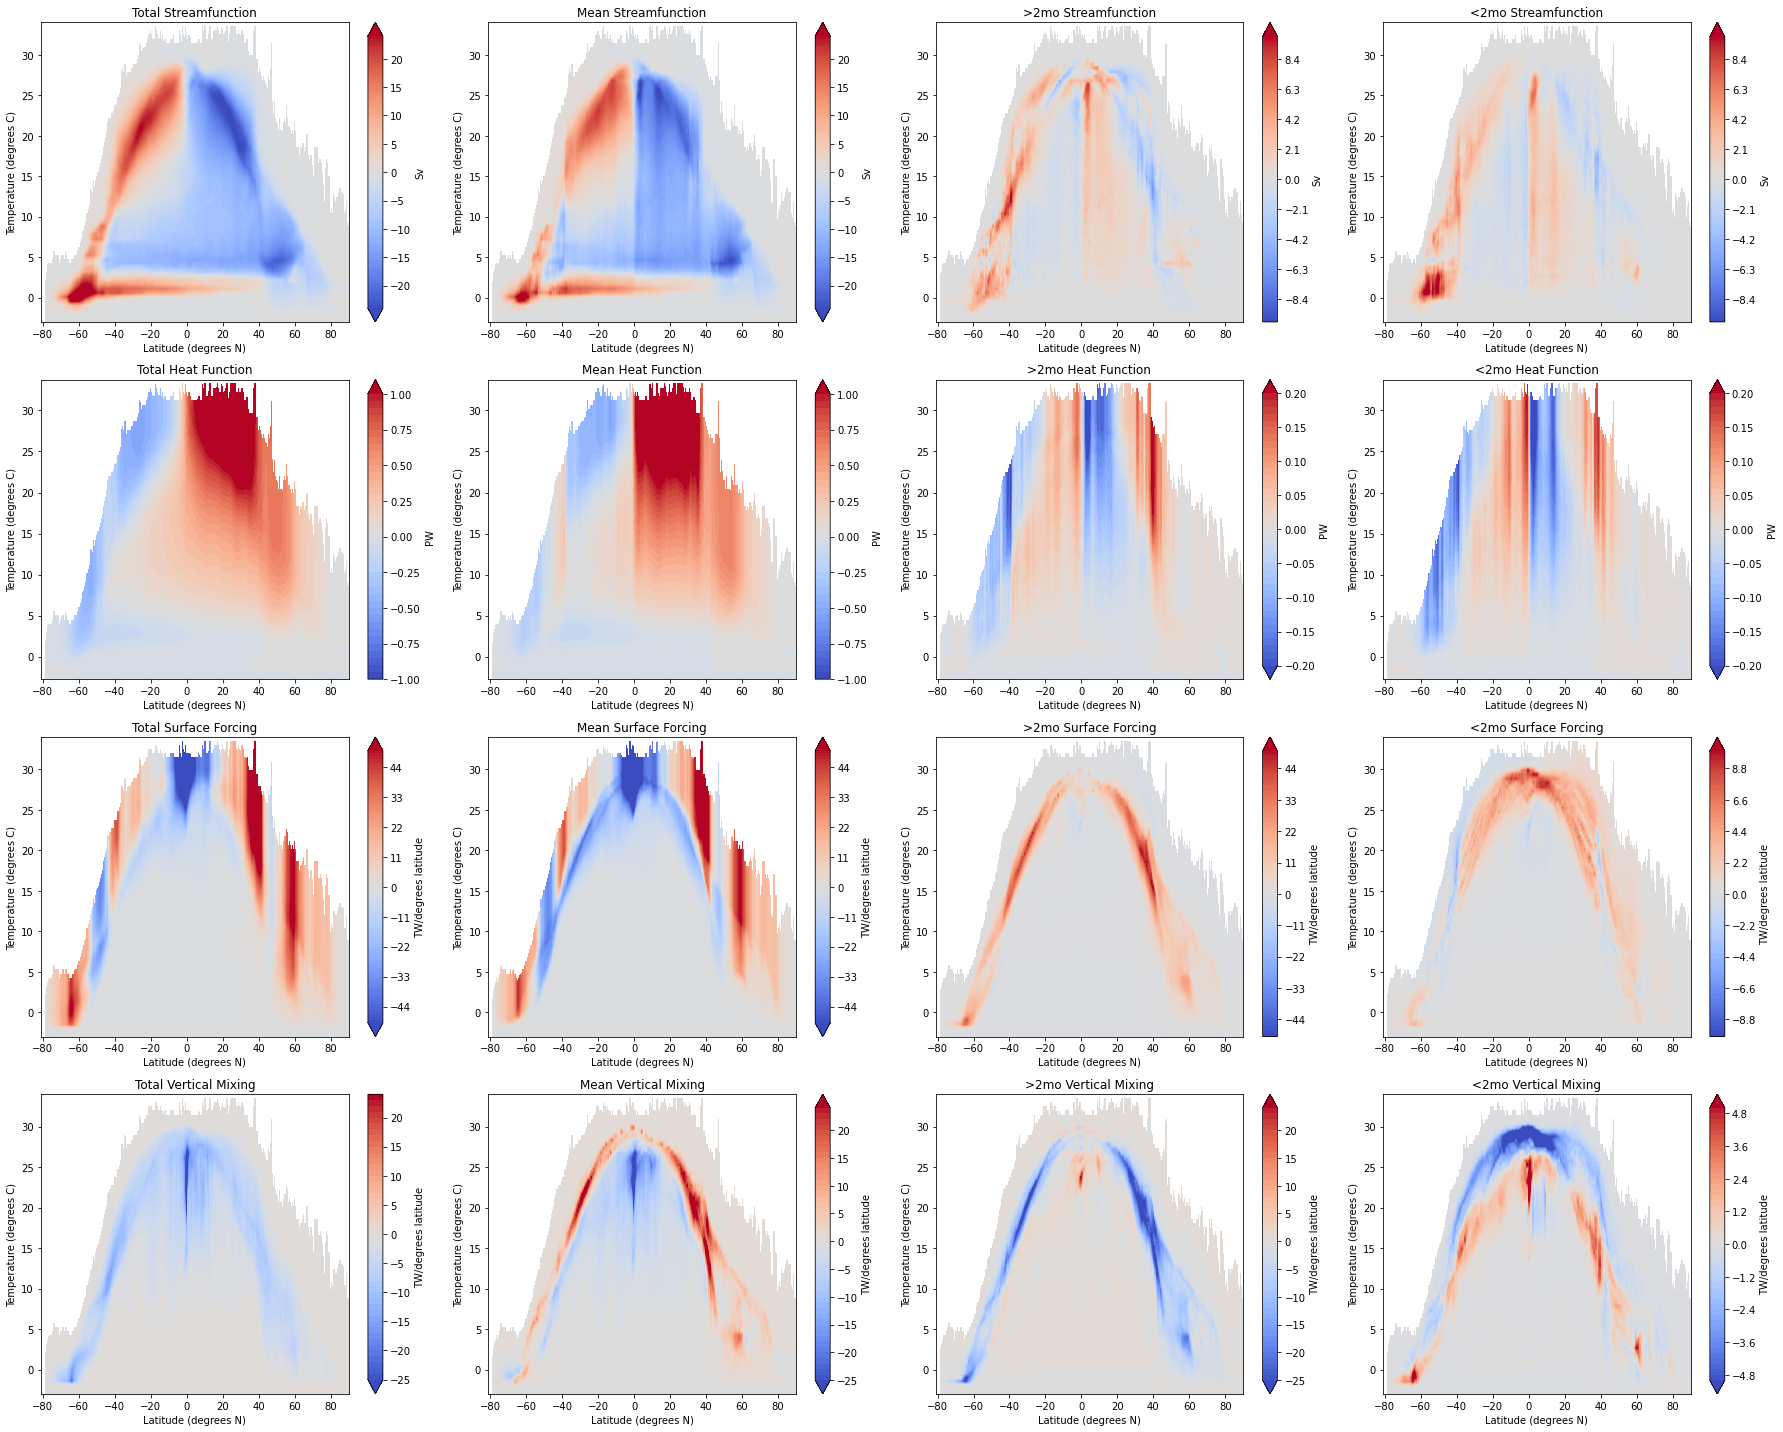

In [14]:
# Plotting:
plt.figure(figsize=(25,20),facecolor='w')

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

cmap = 'coolwarm'

# Saturated bars for the seasonal/eddy terms:
sat = True
if (sat):
    Psicbar_sc = np.arange(-10.,10.1,0.1)
    Hfcbar_sc = np.arange(-0.2,0.21,0.01)
    SFcbar_sc = np.arange(-50.,51.,1.)
    MXcbar_sc = np.arange(-25.,25.,1.)
    Psicbar_e = np.arange(-10.,10.1,0.1)
    Hfcbar_e = np.arange(-0.2,0.21,0.01)
    SFcbar_e = np.arange(-10.,10.2,0.2)
    MXcbar_e = np.arange(-5.,5.2,0.2)
else:
    Psicbar_sc = Psicbar
    Hfcbar_sc = Hfcbar
    SFcbar_sc = SFcbar
    MXcbar_sc = MXcbar
    Psicbar_e = Psicbar
    Hfcbar_e = Hfcbar
    SFcbar_e = SFcbar
    MXcbar_e = MXcbar

plt.subplot(4,4,1)
(Psi_zm_01.where(maskPsi01==1.)/1.e6).plot.contourf(levels=Psicbar,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
plt.title('Total Streamfunction')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,2)
(Psi_mean_tot_zm_01.where(maskPsi01==1.)/1.e6).plot.contourf(levels=Psicbar,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
plt.title('Mean Streamfunction')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,3)
(Psi_ac_zm_01.where(maskPsi01==1.)/1.e6).plot.contourf(levels=Psicbar_sc,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
plt.title('>2mo Streamfunction')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,4)
(Psi_eddy_zm_01.where(maskPsi01==1.)/1.e6).plot.contourf(levels=Psicbar_e,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
plt.title('<2mo Streamfunction')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,5)
(Hf_zm_01.where(maskHf01==1.)/1.e15).plot.contourf(levels=Hfcbar,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
plt.title('Total Heat Function')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,6)
(Hf_mean_tot_zm_01.where(maskHf01==1.)/1.e15).plot.contourf(levels=Hfcbar,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
plt.title('Mean Heat Function')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,7)
(Hf_ac_zm_01.where(maskHf01==1.)/1.e15).plot.contourf(levels=Hfcbar_sc,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
plt.title('>2mo Heat Function')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,8)
(Hf_eddy_zm_01.where(maskHf01==1.)/1.e15).plot.contourf(levels=Hfcbar_e,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
plt.title('<2mo Heat Function')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,9)
(SF_zm_01.where(maskSF01==1.)/1.e12).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('Total Surface Forcing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,10)
(SF_mean_tot_zm_01.where(maskSF01==1.)/1.e12).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('Mean Surface Forcing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,11)
(SF_ac_zm_01.where(maskSF01==1.)/1.e12).plot.contourf(levels=SFcbar_sc,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('>2mo Surface Forcing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,12)
(SF_eddy_zm_01.where(maskSF01==1.)/1.e12).plot.contourf(levels=SFcbar_e,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('<2mo Surface Forcing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,13)
(MX_zm_01.where(maskSF01==1.)/1.e12).plot.contourf(levels=MXcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('Total Vertical Mixing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,14)
(MX_mean_tot_zm_01.where(maskSF01==1.)/1.e12).plot.contourf(levels=MXcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('Mean Vertical Mixing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,15)
(MX_ac_zm_01.where(maskSF01==1.)/1.e12).plot.contourf(levels=MXcbar_sc,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('>2mo Vertical Mixing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.subplot(4,4,16)
(MX_eddy_zm_01.where(maskSF01==1.)/1.e12).plot.contourf(levels=MXcbar_e,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
plt.title('<2mo Vertical Mixing')
plt.ylabel('Temperature (degrees C)')
plt.xlabel('Latitude (degrees N)')

plt.tight_layout()

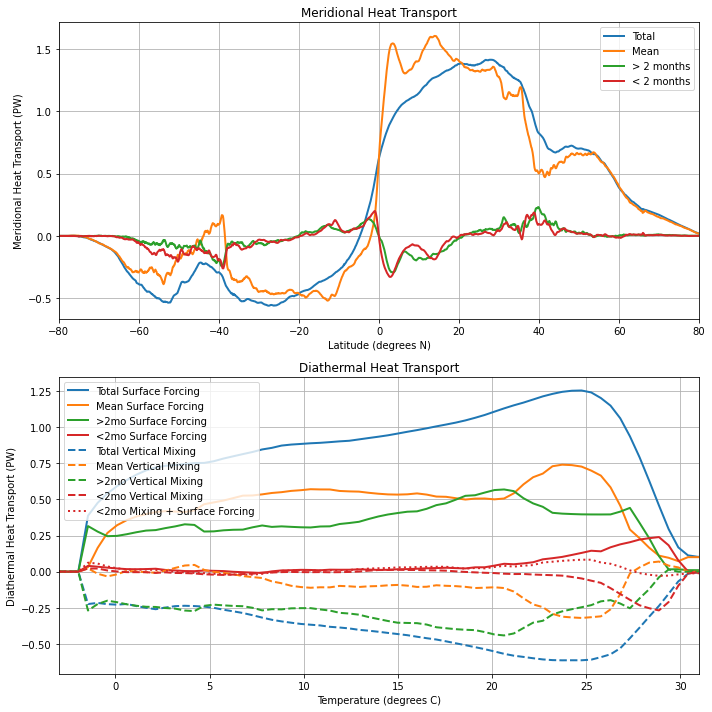

In [57]:
# Totals in temperature and meridional directions:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
(Hf_zm_01/1.e15).isel(neutral=-1).plot(label='Total',linewidth=2)
(Hf_mean_tot_zm_01/1.e15).isel(neutral=-1).plot(label='Mean',linewidth=2)
(Hf_ac_zm_01/1.e15).isel(neutral=-1).plot(label='> 2 months',linewidth=2)
(Hf_eddy_zm_01/1.e15).isel(neutral=-1).plot(label='< 2 months',linewidth=2)
plt.legend()
plt.ylabel('Meridional Heat Transport (PW)')
plt.xlabel('Latitude (degrees N)')
plt.title('Meridional Heat Transport')
plt.grid()
plt.xlim([-80.,80.])

plt.subplot(2,1,2)
(SF_zm_01*dy01/1.e15).sum('grid_yt_ocean').plot(label='Total Surface Forcing',color='C0',linewidth=2)
(SF_mean_tot_zm_01*dy01/1.e15).sum('grid_yt_ocean').plot(label='Mean Surface Forcing',color='C1',linewidth=2)
(SF_ac_zm_01*dy01/1.e15).sum('grid_yt_ocean').plot(label='>2mo Surface Forcing',color='C2',linewidth=2)
(SF_eddy_zm_01*dy01/1.e15).sum('grid_yt_ocean').plot(label='<2mo Surface Forcing',color='C3',linewidth=2)
(MX_zm_01*dy01/1.e15).sum('grid_yt_ocean').plot(label='Total Vertical Mixing',color='C0',linestyle='dashed',linewidth=2)
(MX_mean_tot_zm_01*dy01/1.e15).sum('grid_yt_ocean').plot(label='Mean Vertical Mixing',color='C1',linestyle='dashed',linewidth=2)
(MX_ac_zm_01*dy01/1.e15).sum('grid_yt_ocean').plot(label='>2mo Vertical Mixing',color='C2',linestyle='dashed',linewidth=2)
(MX_eddy_zm_01*dy01/1.e15).sum('grid_yt_ocean').plot(label='<2mo Vertical Mixing',color='C3',linestyle='dashed',linewidth=2)
((MX_eddy_zm_01+SF_eddy_zm_01)*dy01/1.e15).sum('grid_yt_ocean').plot(label='<2mo Mixing + Surface Forcing',color='C3',linestyle='dotted',linewidth=2)
plt.legend(loc='upper left')
plt.ylabel('Diathermal Heat Transport (PW)')
plt.xlabel('Temperature (degrees C)')
plt.title('Diathermal Heat Transport')
plt.grid()
plt.xlim([-3.,31.])

plt.tight_layout()

## Quarter Degree Zonal Means

In [18]:
True_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/True_1year_means_corrected.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/Mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Twomo_mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/2mo_mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Tenday_mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/10day_mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Oneday_mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/1day_mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

In [19]:
# masking:
maskPsi = 0*True_1year_means.Psi.sum('grid_xt_ocean').where(True_1year_means.Psi.sum('grid_xt_ocean')!=True_1year_means.Psi.sum('grid_xt_ocean').isel(neutralrho_edges=-1))+1.
maskHf = gridwm.interp(maskPsi,'T')
maskSF = gridwm.interp(maskPsi,'y',boundary="fill",fill_value=0.)
maskSF

<xarray.DataArray 'mul-e5fda372702e53670ab4c181a14e6bca' (neutralrho_edges: 75,
                                                          grid_yt_ocean: 1080)>
dask.array<mul, shape=(75, 1080), dtype=float64, chunksize=(75, 23), chunktype=numpy.ndarray>
Coordinates:
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0
  * grid_yt_ocean     (grid_yt_ocean) float64 -81.08 -80.97 ... 89.84 89.95

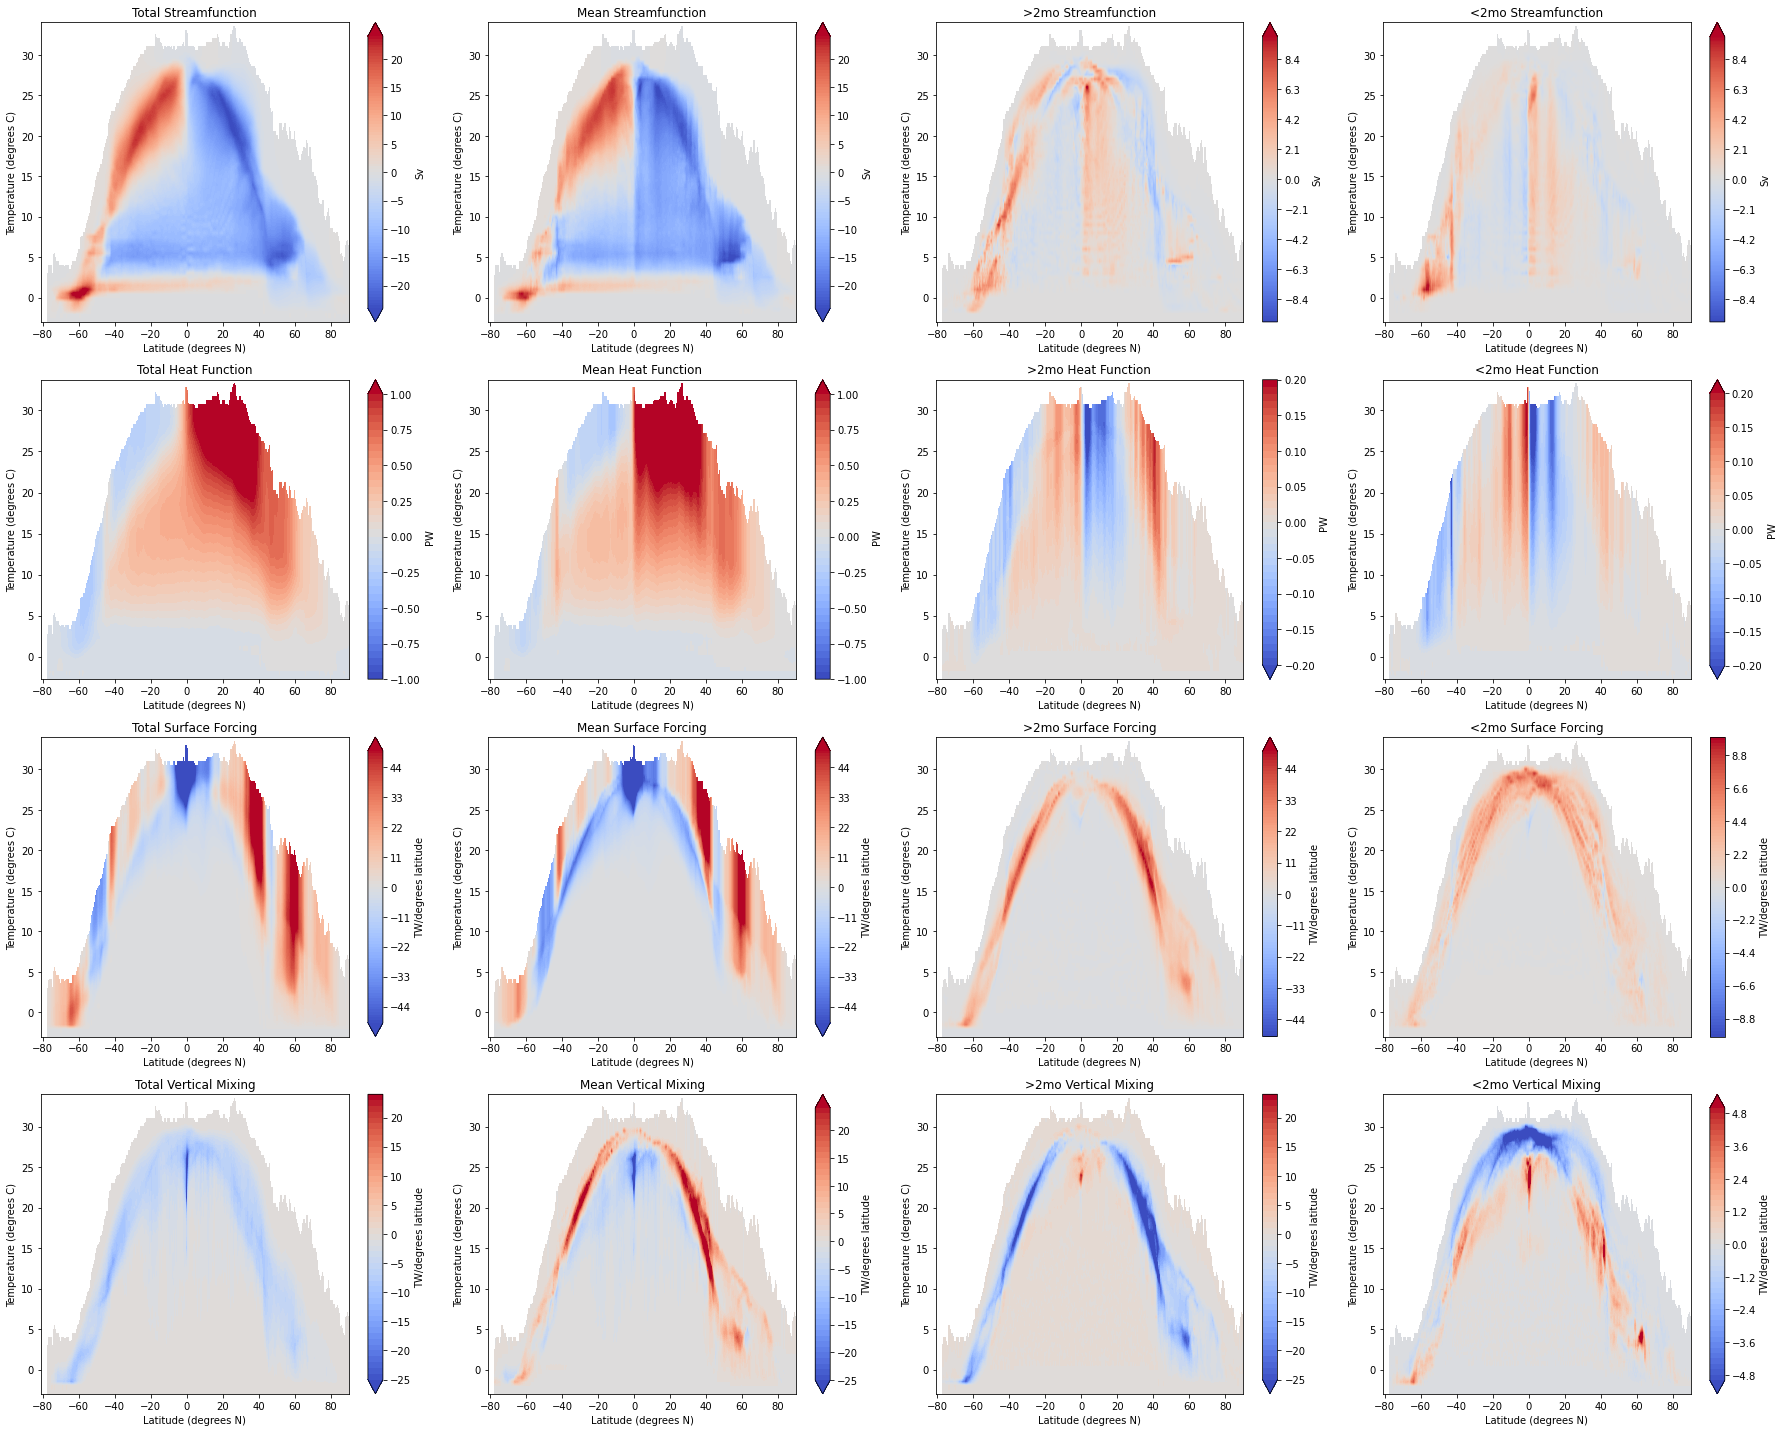

In [20]:
# Plotting:
plt.figure(figsize=(25,20),facecolor='w')

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

cmap = 'coolwarm'

# Saturated bars for the seasonal/eddy terms:
sat = True
if (sat):
    Psicbar_sc = np.arange(-10.,10.1,0.1)
    Hfcbar_sc = np.arange(-0.2,0.21,0.01)
    SFcbar_sc = np.arange(-50.,51.,1.)
    MXcbar_sc = np.arange(-25.,25.,1.)
    Psicbar_e = np.arange(-10.,10.1,0.1)
    Hfcbar_e = np.arange(-0.2,0.21,0.01)
    SFcbar_e = np.arange(-10.,10.2,0.2)
    MXcbar_e = np.arange(-5.,5.2,0.2)
else:
    Psicbar_sc = Psicbar
    Hfcbar_sc = Hfcbar
    SFcbar_sc = SFcbar
    MXcbar_sc = MXcbar
    Psicbar_e = Psicbar
    Hfcbar_e = Hfcbar
    SFcbar_e = SFcbar
    MXcbar_e = MXcbar
    
for i in np.arange(4):
    DataSet = [True_1year_means,Mean_1year_means,Twomo_mean_1year_means - Mean_1year_means,True_1year_means-Twomo_mean_1year_means][i]
    Title = ['Total', 'Mean', '>2mo','<2mo'][i]
    Psicbar_i = [Psicbar, Psicbar, Psicbar_sc, Psicbar_e][i]
    Hfcbar_i = [Hfcbar, Hfcbar, Hfcbar_sc, Hfcbar_e][i]
    SFcbar_i = [SFcbar, SFcbar, SFcbar_sc, SFcbar_e][i]
    MXcbar_i = [MXcbar, MXcbar, MXcbar_sc, MXcbar_e][i]
    
    
    plt.subplot(4,4,i+1)
    (DataSet.Psi.sum('grid_xt_ocean').where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar_i,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
    plt.title(Title+' Streamfunction')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')
    
    Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)
    plt.subplot(4,4,i+5)
    (Hf.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar_i,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
    plt.title(Title+' Heat Function')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(4,4,i+9)
    (DataSet.SF.sum('grid_xt_ocean').where(maskSF==1.)/dy/1.e12).plot.contourf(levels=SFcbar_i,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title(Title+' Surface Forcing')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(4,4,i+13)
    (DataSet.MX.sum('grid_xt_ocean').where(maskSF==1.)/dy/1.e12).plot.contourf(levels=MXcbar_i,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title(Title+' Vertical Mixing')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')




plt.tight_layout()

## Quarter degree maps (no 10th available)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encoun

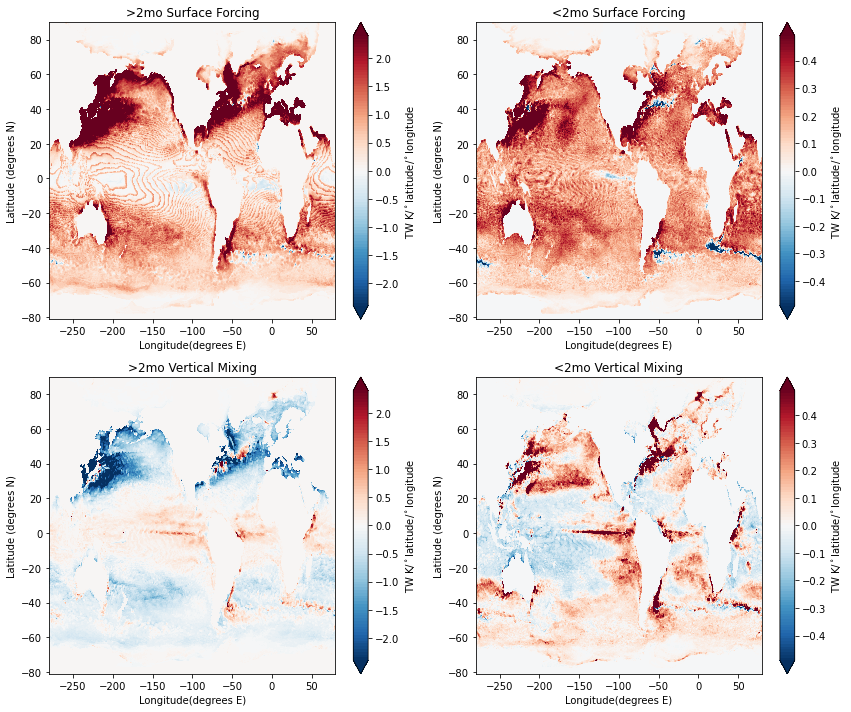

In [21]:
# Plotting:
plt.figure(figsize=(12,10),facecolor='w')

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

cmap = 'RdBu_r'

SFcbar_sc = np.arange(-2.4,2.45,0.05)
MXcbar_sc = np.arange(-2.4,2.45,0.05)
SFcbar_e =  np.arange(-0.49,0.5,0.01)
MXcbar_e =  np.arange(-0.49,0.5,0.01)


DataSet = Twomo_mean_1year_means - Mean_1year_means
plt.subplot(2,2,1)
(DataSet.SF.sum('neutralrho_edges')/dx/dy/1.e12).plot.contourf(levels=SFcbar_sc,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
plt.title('>2mo Surface Forcing')
plt.xlabel('Longitude(degrees E)')
plt.ylabel('Latitude (degrees N)')

plt.subplot(2,2,3)
(DataSet.MX.sum('neutralrho_edges')/dx/dy/1.e12).plot.contourf(levels=MXcbar_sc,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
plt.title('>2mo Vertical Mixing')
plt.xlabel('Longitude(degrees E)')
plt.ylabel('Latitude (degrees N)')

DataSet = True_1year_means-Twomo_mean_1year_means
plt.subplot(2,2,2)
(DataSet.SF.sum('neutralrho_edges')/dx/dy/1.e12).plot.contourf(levels=SFcbar_e,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
plt.title('<2mo Surface Forcing')
plt.xlabel('Longitude(degrees E)')
plt.ylabel('Latitude (degrees N)')


plt.subplot(2,2,4)
(DataSet.MX.sum('neutralrho_edges')/dx/dy/1.e12).plot.contourf(levels=MXcbar_e,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
plt.title('<2mo Vertical Mixing')
plt.xlabel('Longitude(degrees E)')
plt.ylabel('Latitude (degrees N)')

plt.tight_layout()

In [22]:
SF_025 = True_1year_means.SF
SF_mean_tot_025 = Mean_1year_means.SF
SF_ac_025 = (Twomo_mean_1year_means - Mean_1year_means).SF
SF_eddy_025 = (True_1year_means - Twomo_mean_1year_means).SF

MX_025 = True_1year_means.MX
MX_mean_tot_025 = Mean_1year_means.MX
MX_ac_025 = (Twomo_mean_1year_means - Mean_1year_means).MX
MX_eddy_025 = (True_1year_means - Twomo_mean_1year_means).MX

Hf_025 = -Cp*rho0*dT*gridwm.cumsum(True_1year_means.Psi,'T',boundary="fill", fill_value=0)
Hf_mean_tot_025 = -Cp*rho0*dT*gridwm.cumsum(Mean_1year_means.Psi,'T',boundary="fill", fill_value=0)
Hf_ac_025 = -Cp*rho0*dT*gridwm.cumsum((Twomo_mean_1year_means - Mean_1year_means).Psi,'T',boundary="fill", fill_value=0)
Hf_eddy_025 = -Cp*rho0*dT*gridwm.cumsum((True_1year_means - Twomo_mean_1year_means).Psi,'T',boundary="fill", fill_value=0)


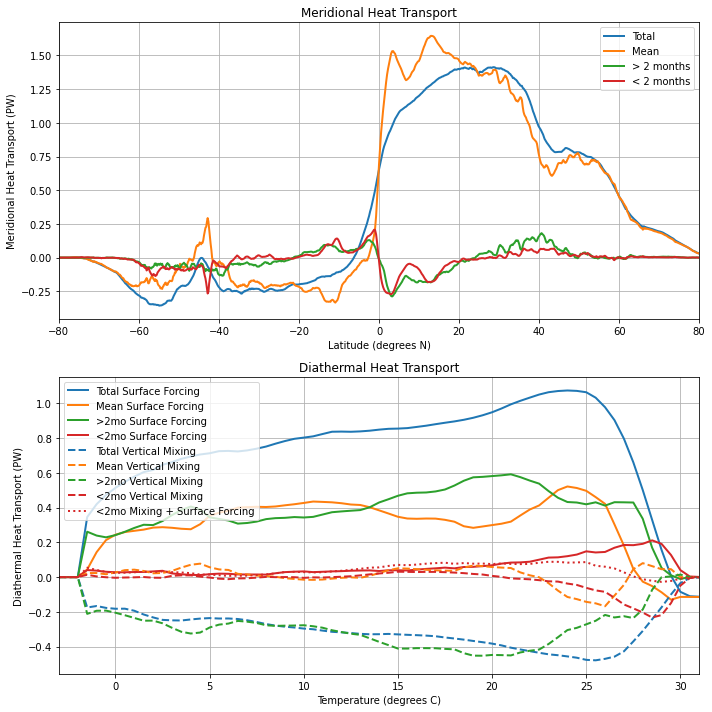

In [23]:
# Totals in temperature and meridional directions:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
(Hf_025.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='Total',linewidth=2)
(Hf_mean_tot_025.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='Mean',linewidth=2)
(Hf_ac_025.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='> 2 months',linewidth=2)
(Hf_eddy_025.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='< 2 months',linewidth=2)
plt.legend()
plt.ylabel('Meridional Heat Transport (PW)')
plt.xlabel('Latitude (degrees N)')
plt.title('Meridional Heat Transport')
plt.grid()
plt.xlim([-80.,80.])

plt.subplot(2,1,2)
(SF_025.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Total Surface Forcing',color='C0',linewidth=2)
(SF_mean_tot_025.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Mean Surface Forcing',color='C1',linewidth=2)
(SF_ac_025.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='>2mo Surface Forcing',color='C2',linewidth=2)
(SF_eddy_025.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='<2mo Surface Forcing',color='C3',linewidth=2)
(MX_025.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Total Vertical Mixing',color='C0',linestyle='dashed',linewidth=2)
(MX_mean_tot_025.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Mean Vertical Mixing',color='C1',linestyle='dashed',linewidth=2)
(MX_ac_025.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='>2mo Vertical Mixing',color='C2',linestyle='dashed',linewidth=2)
(MX_eddy_025.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='<2mo Vertical Mixing',color='C3',linestyle='dashed',linewidth=2)
((MX_eddy_025+SF_eddy_025).sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='<2mo Mixing + Surface Forcing',color='C3',linestyle='dotted',linewidth=2)
plt.legend(loc='upper left')
plt.ylabel('Diathermal Heat Transport (PW)')
plt.xlabel('Temperature (degrees C)')
plt.title('Diathermal Heat Transport')
plt.grid()
plt.xlim([-3.,31.])

plt.tight_layout()

# 1 degree zonal means

In [24]:
# One degree (x,y,temp) datasets
path = '/scratch/e14/cy8964/temp/1deg_101/'
True_1year_means_1 = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/True_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})
Twomo_mean_1year_means_1 = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/2mo_mean_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})
Mean_1year_means_1 = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/Mean_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})

In [25]:
# masking:
maskPsi1 = 0*True_1year_means_1.Psi.sum('grid_xt_ocean').where(True_1year_means_1.Psi.sum('grid_xt_ocean')!=True_1year_means_1.Psi.sum('grid_xt_ocean').isel(neutralrho_edges=-1))+1.
maskHf1 = gridwm1.interp(maskPsi1,'T')
maskSF1 = gridwm1.interp(maskPsi1,'y',boundary="fill",fill_value=0.)
maskSF1

<xarray.DataArray 'mul-f0a15b1ff9de7da2eb9a35833de8ba2c' (neutralrho_edges: 75,
                                                          grid_yt_ocean: 300)>
dask.array<mul, shape=(75, 300), dtype=float64, chunksize=(75, 239), chunktype=numpy.ndarray>
Coordinates:
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0
  * grid_yt_ocean     (grid_yt_ocean) float64 -77.88 -77.63 ... 89.32 89.77

In [29]:
True_1year_means_1.SF

<xarray.DataArray 'SF' (neutralrho_edges: 75, grid_yt_ocean: 300,
                        grid_xt_ocean: 360)>
dask.array<rechunk-merge, shape=(75, 300, 360), dtype=float64, chunksize=(75, 240, 360), chunktype=numpy.ndarray>
Coordinates:
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0
  * grid_xt_ocean     (grid_xt_ocean) float64 -279.5 -278.5 -277.5 ... 78.5 79.5
  * grid_yt_ocean     (grid_yt_ocean) float64 -77.88 -77.63 ... 89.32 89.77

In [26]:
SF_1 = True_1year_means_1.SF
SF_mean_tot_1 = Mean_1year_means_1.SF
SF_ac_1 = (Twomo_mean_1year_means_1 - Mean_1year_means_1).SF
SF_eddy_1 = (True_1year_means_1 - Twomo_mean_1year_means_1).SF

MX_1 = True_1year_means_1.MX
MX_mean_tot_1 = Mean_1year_means_1.MX
MX_ac_1 = (Twomo_mean_1year_means_1 - Mean_1year_means_1).MX
MX_eddy_1 = (True_1year_means_1 - Twomo_mean_1year_means_1).MX

Hf_1 = -Cp*rho0*dT1*gridwm1.cumsum(True_1year_means_1.Psi,'T',boundary="fill", fill_value=0)
Hf_mean_tot_1 = -Cp*rho0*dT1*gridwm1.cumsum(Mean_1year_means_1.Psi,'T',boundary="fill", fill_value=0)
Hf_ac_1 = -Cp*rho0*dT1*gridwm1.cumsum((Twomo_mean_1year_means_1 - Mean_1year_means_1).Psi,'T',boundary="fill", fill_value=0)
Hf_eddy_1 = -Cp*rho0*dT1*gridwm1.cumsum((True_1year_means_1 - Twomo_mean_1year_means_1).Psi,'T',boundary="fill", fill_value=0)


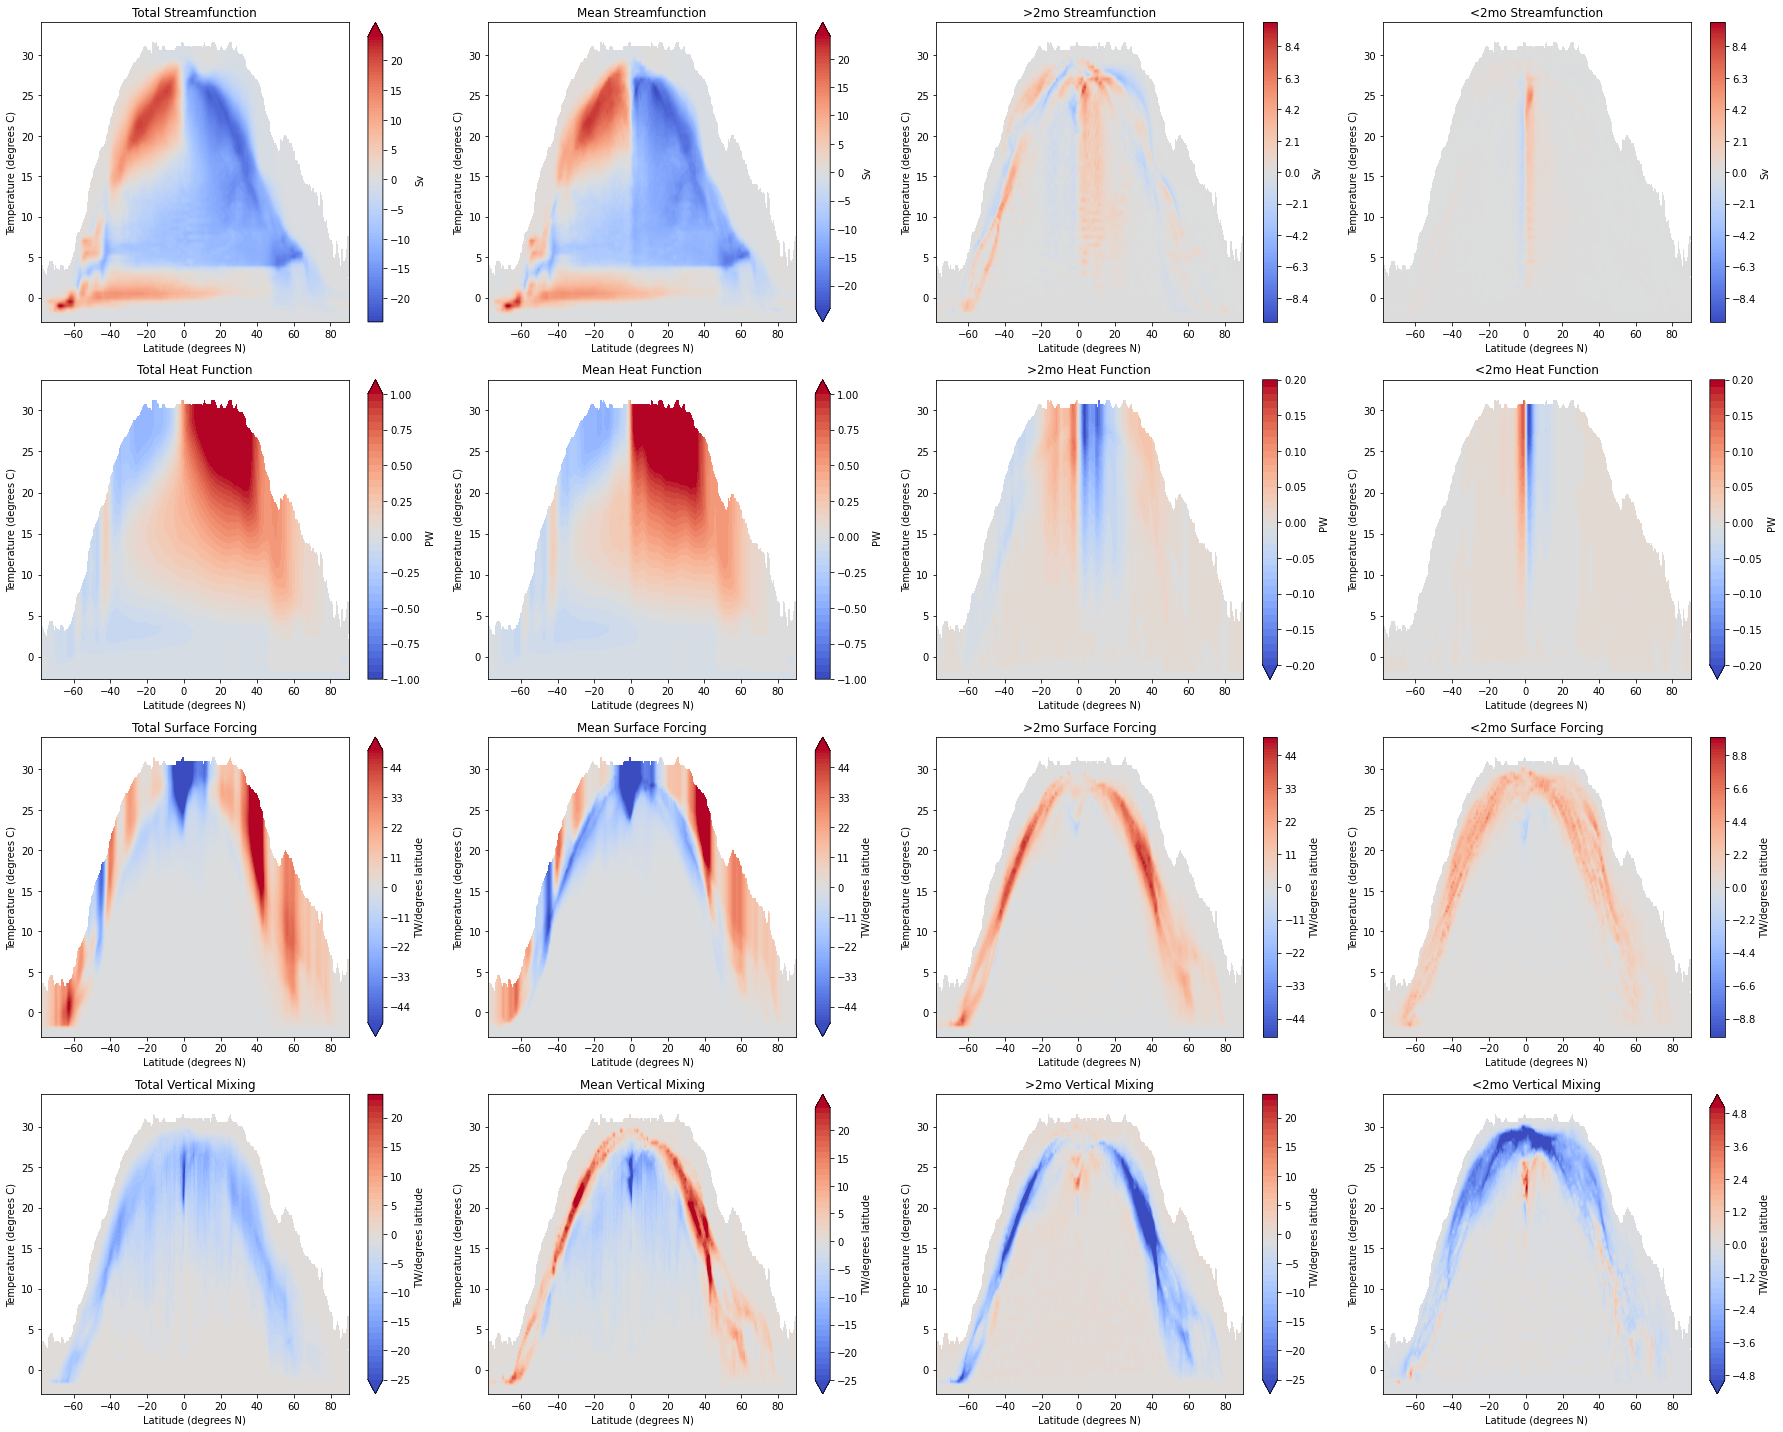

In [30]:
# Plotting:
plt.figure(figsize=(25,20),facecolor='w')

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

cmap = 'coolwarm'

# Saturated bars for the seasonal/eddy terms:
sat = True
if (sat):
    Psicbar_sc = np.arange(-10.,10.1,0.1)
    Hfcbar_sc = np.arange(-0.2,0.21,0.01)
    SFcbar_sc = np.arange(-50.,51.,1.)
    MXcbar_sc = np.arange(-25.,25.,1.)
    Psicbar_e = np.arange(-10.,10.1,0.1)
    Hfcbar_e = np.arange(-0.2,0.21,0.01)
    SFcbar_e = np.arange(-10.,10.2,0.2)
    MXcbar_e = np.arange(-5.,5.2,0.2)
else:
    Psicbar_sc = Psicbar
    Hfcbar_sc = Hfcbar
    SFcbar_sc = SFcbar
    MXcbar_sc = MXcbar
    Psicbar_e = Psicbar
    Hfcbar_e = Hfcbar
    SFcbar_e = SFcbar
    MXcbar_e = MXcbar
    
for i in np.arange(4):
    DataSet = [True_1year_means_1,Mean_1year_means_1,Twomo_mean_1year_means_1 - Mean_1year_means_1,True_1year_means_1-Twomo_mean_1year_means_1][i]
    Title = ['Total', 'Mean', '>2mo','<2mo'][i]
    Psicbar_i = [Psicbar, Psicbar, Psicbar_sc, Psicbar_e][i]
    Hfcbar_i = [Hfcbar, Hfcbar, Hfcbar_sc, Hfcbar_e][i]
    SFcbar_i = [SFcbar, SFcbar, SFcbar_sc, SFcbar_e][i]
    MXcbar_i = [MXcbar, MXcbar, MXcbar_sc, MXcbar_e][i]
    
    
    plt.subplot(4,4,i+1)
    (DataSet.Psi.sum('grid_xt_ocean').where(maskPsi1==1.)/1.e6).plot.contourf(levels=Psicbar_i,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
    plt.title(Title+' Streamfunction')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')
    
    Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)
    plt.subplot(4,4,i+5)
    (Hf.sum('grid_xt_ocean').where(maskHf1==1.)/1.e15).plot.contourf(levels=Hfcbar_i,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
    plt.title(Title+' Heat Function')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(4,4,i+9)
    (DataSet.SF.sum('grid_xt_ocean').where(maskSF1==1.)/dy1/1.e12).plot.contourf(levels=SFcbar_i,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title(Title+' Surface Forcing')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(4,4,i+13)
    (DataSet.MX.sum('grid_xt_ocean').where(maskSF1==1.)/dy1/1.e12).plot.contourf(levels=MXcbar_i,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title(Title+' Vertical Mixing')
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')




plt.tight_layout()

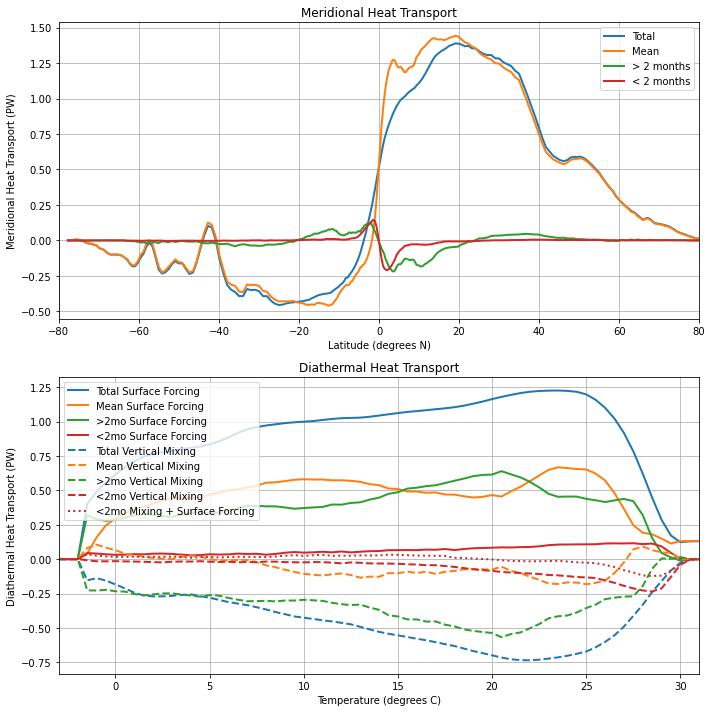

In [31]:
# Totals in temperature and meridional directions:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
(Hf_1.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='Total',linewidth=2)
(Hf_mean_tot_1.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='Mean',linewidth=2)
(Hf_ac_1.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='> 2 months',linewidth=2)
(Hf_eddy_1.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='< 2 months',linewidth=2)
plt.legend()
plt.ylabel('Meridional Heat Transport (PW)')
plt.xlabel('Latitude (degrees N)')
plt.title('Meridional Heat Transport')
plt.grid()
plt.xlim([-80.,80.])

plt.subplot(2,1,2)
(SF_1.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Total Surface Forcing',color='C0',linewidth=2)
(SF_mean_tot_1.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Mean Surface Forcing',color='C1',linewidth=2)
(SF_ac_1.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='>2mo Surface Forcing',color='C2',linewidth=2)
(SF_eddy_1.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='<2mo Surface Forcing',color='C3',linewidth=2)
(MX_1.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Total Vertical Mixing',color='C0',linestyle='dashed',linewidth=2)
(MX_mean_tot_1.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Mean Vertical Mixing',color='C1',linestyle='dashed',linewidth=2)
(MX_ac_1.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='>2mo Vertical Mixing',color='C2',linestyle='dashed',linewidth=2)
(MX_eddy_1.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='<2mo Vertical Mixing',color='C3',linestyle='dashed',linewidth=2)
((MX_eddy_1+SF_eddy_1).sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='<2mo Mixing + Surface Forcing',color='C3',linestyle='dotted',linewidth=2)
plt.legend(loc='upper left')
plt.ylabel('Diathermal Heat Transport (PW)')
plt.xlabel('Temperature (degrees C)')
plt.title('Diathermal Heat Transport')
plt.grid()
plt.xlim([-3.,31.])

plt.tight_layout()

## Integral of eddy terms

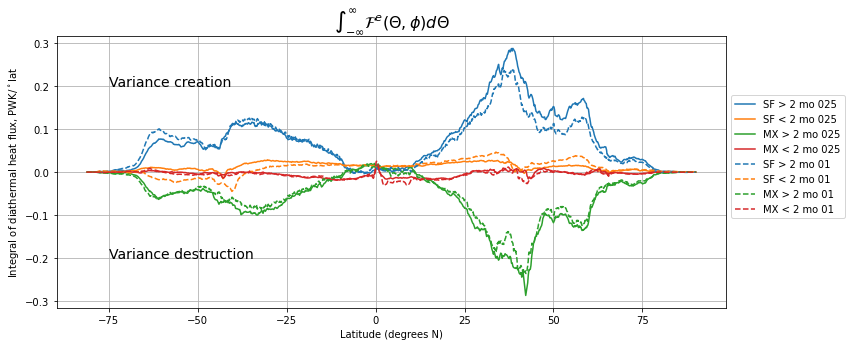

2022-05-16 11:13:14,386 - distributed.nanny - WARNING - Restarting worker
2022-05-16 11:13:14,390 - distributed.nanny - WARNING - Restarting worker
2022-05-16 11:13:14,536 - distributed.nanny - WARNING - Restarting worker
2022-05-16 11:13:14,698 - distributed.worker_memory - WARNING - Worker exceeded 95% memory budget. Restarting
2022-05-16 11:13:14,866 - distributed.nanny - WARNING - Restarting worker
2022-05-16 11:13:14,876 - distributed.nanny - WARNING - Restarting worker
2022-05-16 11:13:14,997 - distributed.nanny - WARNING - Restarting worker
2022-05-16 11:13:15,125 - distributed.nanny - WARNING - Restarting worker
2022-05-16 11:13:15,247 - distributed.nanny - WARNING - Restarting worker
2022-05-16 11:13:15,490 - distributed.worker_memory - WARNING - Worker exceeded 95% memory budget. Restarting
2022-05-16 11:13:15,511 - distributed.nanny - WARNING - Restarting worker
2022-05-16 11:13:15,515 - distributed.nanny - WARNING - Restarting worker
2022-05-16 11:13:15,762 - distributed.na

In [81]:
fig = plt.figure(figsize = (12,5))
(SF_ac_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'SF > 2 mo 025', color = 'C0',linestyle = '-')
(SF_eddy_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'SF < 2 mo 025', color = 'C1',linestyle = '-')
(MX_ac_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'MX > 2 mo 025', color = 'C2',linestyle = '-')
(MX_eddy_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'MX < 2 mo 025', color = 'C3',linestyle = '-') 

(SF_ac_zm_01/1.e15*dT01).sum('neutralrho_edges').plot(label = 'SF > 2 mo 01', color = 'C0',linestyle = '--')
(SF_eddy_zm_01/1.e15*dT01).sum('neutralrho_edges').plot(label = 'SF < 2 mo 01', color = 'C1',linestyle = '--')
(MX_ac_zm_01/1.e15*dT01).sum('neutralrho_edges').plot(label = 'MX > 2 mo 01', color = 'C2',linestyle = '--')
(MX_eddy_zm_01/1.e15*dT01).sum('neutralrho_edges').plot(label = 'MX < 2 mo 01', color = 'C3',linestyle = '--')

plt.ylabel('Integral of diathermal heat flux, PWK/$^\circ$lat')
plt.xlabel('Latitude (degrees N)')
plt.legend(bbox_to_anchor = (1,0.8), loc = 'upper left')
plt.title('$\int_{-\infty}^{\infty} \mathcal{F}^e(\Theta,\phi)d\Theta$', fontsize = 16)

plt.text(-75,0.2,'Variance creation',fontsize = 14)
plt.text(-75,-0.2,'Variance destruction',fontsize = 14)
plt.grid()

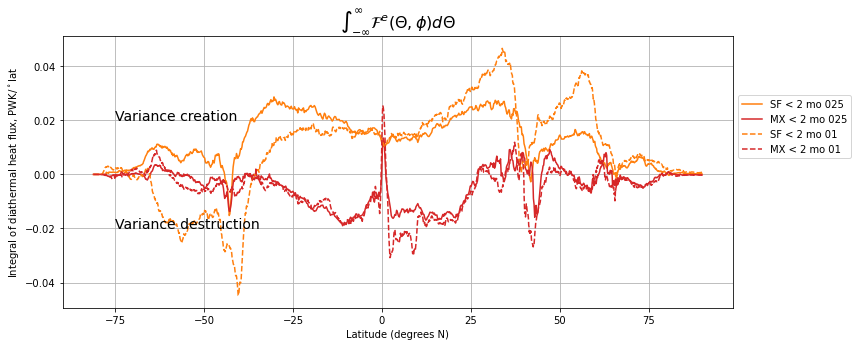

In [80]:
fig = plt.figure(figsize = (12,5))

#(SF_ac_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'SF > 2 mo 025', color = 'C0',linestyle = '-')
(SF_eddy_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'SF < 2 mo 025', color = 'C1',linestyle = '-')
#(MX_ac_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'MX > 2 mo 025', color = 'C2',linestyle = '-')
(MX_eddy_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'MX < 2 mo 025', color = 'C3',linestyle = '-') 

#(SF_ac_zm_01/1.e15*dT01).sum('neutralrho_edges').plot(label = 'SF > 2 mo 01', color = 'C0',linestyle = '--')
(SF_eddy_zm_01/1.e15*dT01).sum('neutralrho_edges').plot(label = 'SF < 2 mo 01', color = 'C1',linestyle = '--')
#(MX_ac_zm_01/1.e15*dT01).sum('neutralrho_edges').plot(label = 'MX > 2 mo 01', color = 'C2',linestyle = '--')
(MX_eddy_zm_01/1.e15*dT01).sum('neutralrho_edges').plot(label = 'MX < 2 mo 01', color = 'C3',linestyle = '--')

plt.ylabel('Integral of diathermal heat flux, PWK/$^\circ$lat')
plt.xlabel('Latitude (degrees N)')
plt.legend(bbox_to_anchor = (1,0.8), loc = 'upper left')
plt.title('$\int_{-\infty}^{\infty} \mathcal{F}^e(\Theta,\phi)d\Theta$', fontsize = 16)

plt.text(-75,0.02,'Variance creation',fontsize = 14)
plt.text(-75,-0.02,'Variance destruction',fontsize = 14)
plt.grid()

notes:
- can see extra blue bits in Southern Ocena eddies in 10th degree
- mixing mostly negative, SF mostly positive (since includes diurnal cycle in < 2 months term)
- However at equator mixing term positive, TIW mixing creating variance. So that can be a focus?

## with 1 deg too

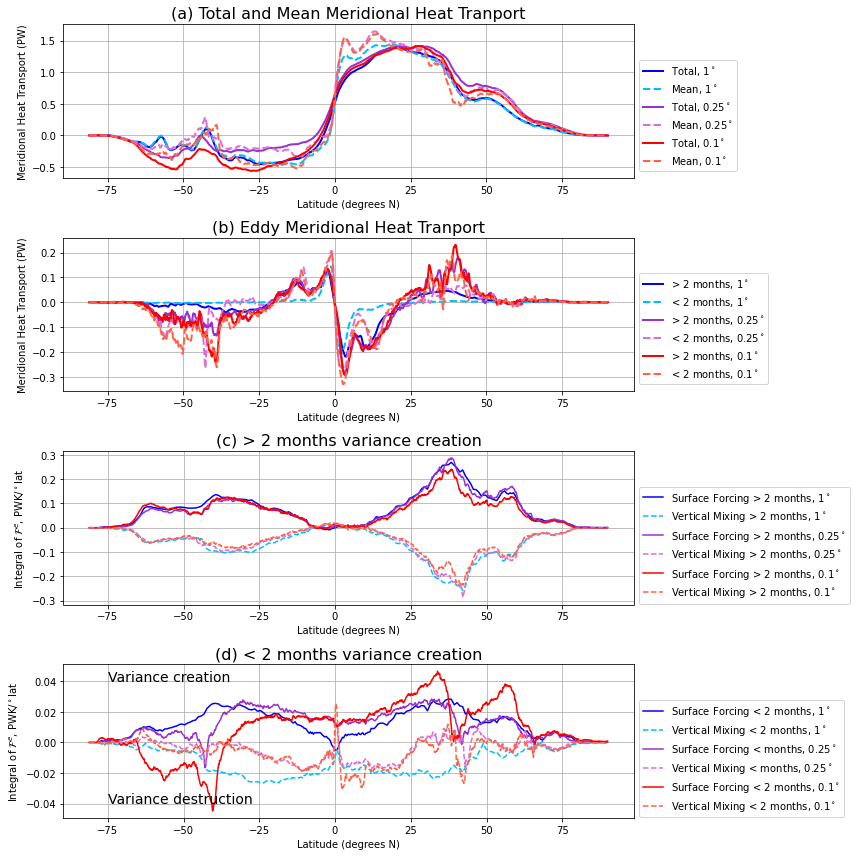

2022-06-07 11:39:42,430 - distributed.nanny - WARNING - Restarting worker
2022-06-07 11:39:42,622 - distributed.nanny - WARNING - Restarting worker
2022-06-07 11:39:42,624 - distributed.nanny - WARNING - Restarting worker
2022-06-07 11:39:42,724 - distributed.nanny - WARNING - Restarting worker
2022-06-07 11:39:42,988 - distributed.nanny - WARNING - Restarting worker
2022-06-07 11:39:42,993 - distributed.nanny - WARNING - Restarting worker
2022-06-07 11:39:43,014 - distributed.nanny - WARNING - Restarting worker
2022-06-07 11:39:43,207 - distributed.nanny - WARNING - Restarting worker
2022-06-07 11:39:43,491 - distributed.nanny - WARNING - Restarting worker
2022-06-07 11:39:43,494 - distributed.nanny - WARNING - Restarting worker
2022-06-07 11:39:43,594 - distributed.nanny - WARNING - Restarting worker
2022-06-07 11:39:43,691 - distributed.nanny - WARNING - Restarting worker
2022-06-07 11:39:43,787 - distributed.nanny - WARNING - Restarting worker
2022-06-07 11:39:43,880 - distributed.

In [35]:
fig = plt.figure(figsize = (12,12))
plt.subplot(4,1,1)
(Hf_1.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='Total, 1$^\circ$',linewidth=2, color = 'blue',linestyle = '-')
(Hf_mean_tot_1.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='Mean, 1$^\circ$',linewidth=2, color = 'deepskyblue',linestyle = '--')
(Hf_025.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='Total, 0.25$^\circ$',linewidth=2, color = 'darkorchid',linestyle = '-')
(Hf_mean_tot_025.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='Mean, 0.25$^\circ$',linewidth=2, color = 'orchid',linestyle = '--')
(Hf_zm_01/1.e15).isel(neutral=-1).plot(label='Total, 0.1$^\circ$',linewidth=2, color =  'r',linestyle = '-')
(Hf_mean_tot_zm_01/1.e15).isel(neutral=-1).plot(label='Mean, 0.1$^\circ$',linewidth=2, color =  'tomato',linestyle = '--')

plt.ylabel('Meridional Heat Transport (PW)')
plt.xlabel('Latitude (degrees N)')
plt.legend(bbox_to_anchor = (1,0.8), loc = 'upper left')
plt.title('(a) Total and Mean Meridional Heat Tranport', fontsize = 16)
plt.grid()

plt.subplot(4,1,2)
(Hf_ac_1.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='> 2 months, 1$^\circ$',linewidth=2, color = 'blue',linestyle = '-')
(Hf_eddy_1.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='< 2 months, 1$^\circ$',linewidth=2, color = 'deepskyblue',linestyle = '--')
(Hf_ac_025.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='> 2 months, 0.25$^\circ$',linewidth=2, color = 'darkorchid',linestyle = '-')
(Hf_eddy_025.sum('grid_xt_ocean')/1.e15).isel(neutral=-1).plot(label='< 2 months, 0.25$^\circ$',linewidth=2, color = 'orchid',linestyle = '--')
(Hf_ac_zm_01/1.e15).isel(neutral=-1).plot(label='> 2 months, 0.1$^\circ$',linewidth=2, color = 'r',linestyle = '-')
(Hf_eddy_zm_01/1.e15).isel(neutral=-1).plot(label='< 2 months, 0.1$^\circ$',linewidth=2, color = 'tomato',linestyle = '--')

plt.ylabel('Meridional Heat Transport (PW)')
plt.xlabel('Latitude (degrees N)')
plt.legend(bbox_to_anchor = (1,0.8), loc = 'upper left')
plt.title('(b) Eddy Meridional Heat Tranport', fontsize = 16)
plt.grid()

plt.subplot(4,1,3)

(SF_ac_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = 'Surface Forcing > 2 months, 1$^\circ$', color = 'blue',linestyle = '-')
(MX_ac_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = 'Vertical Mixing > 2 months, 1$^\circ$', color = 'deepskyblue',linestyle = '--')
(SF_ac_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'Surface Forcing > 2 months, 0.25$^\circ$', color = 'darkorchid',linestyle = '-')
(MX_ac_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'Vertical Mixing > 2 months, 0.25$^\circ$', color = 'orchid',linestyle = '--')
(SF_ac_zm_01/1.e15*dT01).sum('neutralrho_edges').plot(label = 'Surface Forcing > 2 months, 0.1$^\circ$', color =  'r',linestyle = '-')
(MX_ac_zm_01/1.e15*dT01).sum('neutralrho_edges').plot(label = 'Vertical Mixing > 2 months, 0.1$^\circ$', color =  'tomato',linestyle = '--')

plt.ylabel('Integral of $\mathcal{F}^e$, PWK/$^\circ$lat')
plt.xlabel('Latitude (degrees N)')
plt.legend(bbox_to_anchor = (1,0.8), loc = 'upper left')
plt.title('(c) > 2 months variance creation', fontsize = 16)
plt.grid()

plt.subplot(4,1,4)

(SF_eddy_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = 'Surface Forcing < 2 months, 1$^\circ$', color = 'blue',linestyle = '-')
(MX_eddy_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = 'Vertical Mixing < 2 months, 1$^\circ$', color = 'deepskyblue',linestyle = '--')
(SF_eddy_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'Surface Forcing < months, 0.25$^\circ$', color = 'darkorchid',linestyle = '-')
(MX_eddy_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'Vertical Mixing < months, 0.25$^\circ$', color = 'orchid',linestyle = '--')
(SF_eddy_zm_01/1.e15*dT01).sum('neutralrho_edges').plot(label = 'Surface Forcing < 2 months, 0.1$^\circ$', color =  'r',linestyle = '-')
(MX_eddy_zm_01/1.e15*dT01).sum('neutralrho_edges').plot(label = 'Vertical Mixing < 2 months, 0.1$^\circ$', color =  'tomato',linestyle = '--')

plt.ylabel('Integral of $\mathcal{F}^e$, PWK/$^\circ$lat')
plt.xlabel('Latitude (degrees N)')
plt.legend(bbox_to_anchor = (1,0.8), loc = 'upper left')
plt.title('(d) < 2 months variance creation', fontsize = 16)

plt.text(-75,0.04,'Variance creation',fontsize = 14)
plt.text(-75,-0.04,'Variance destruction',fontsize = 14)
plt.grid()

plt.tight_layout()
plt.savefig('comparison_resolutions.png',dpi = 200)

## compare diurnal cycles

In [11]:
path = '/scratch/e14/cy8964/temp/1deg_101/'
path2 = '/scratch/e14/cy8964/temp/1deg_102_10yr/'
True_1year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/True_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})
SF_1day = xr.open_dataarray(path+'1daily_mean_1year_means_SF_1day.nc')
MX_1day= xr.open_dataarray(path+'1daily_mean_1year_means_MX_1day.nc')

SF_diurnal_1 = True_1year_means_1.SF - SF_1day
MX_diurnal_1 = True_1year_means_1.MX - MX_1day


In [17]:
xch = 1440#2*288
ych = 1080#2*216

True_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/True_1year_means_corrected.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/Mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Twomo_mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/2mo_mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Tenday_mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/10day_mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Oneday_mean_1year_means = xr.open_mfdataset('/g/data/e14/cy8964/Post_Process/temp/025deg_096_3d/1day_mean_1year_means.nc').chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

In [18]:
SF_diurnal_025 = True_1year_means.SF - Oneday_mean_1year_means.SF
MX_diurnal_025 = True_1year_means.MX - Oneday_mean_1year_means.MX


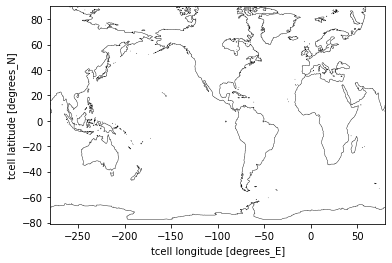

In [13]:
mask = (fgrd.ht.where(fgrd.ht>0)*0+1).fillna(0)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


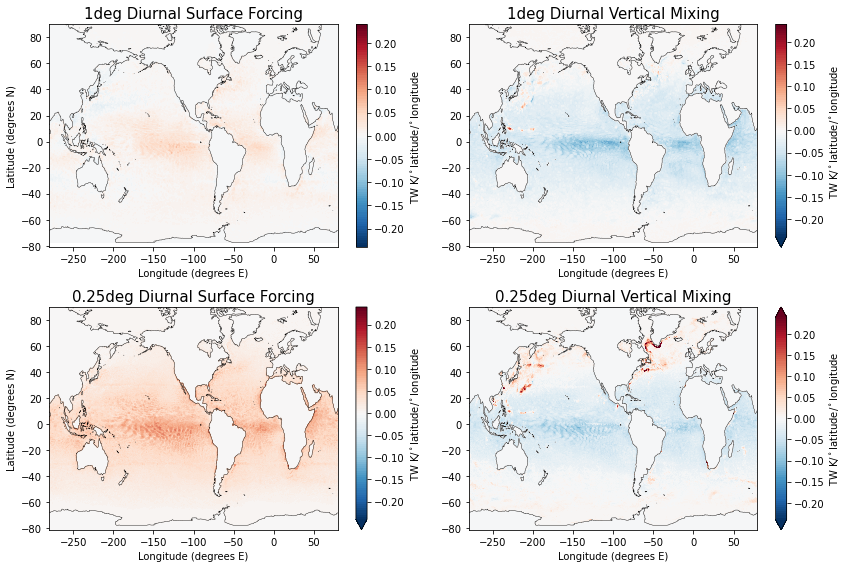

2022-06-10 16:52:17,818 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:17,825 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,110 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,114 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,192 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,284 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,374 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,553 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,643 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,663 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,745 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,828 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,920 - distributed.nanny - WARNING - Restarting worker
2022-06-10 16:52:18,995 - distributed.

In [26]:
fig = plt.figure(figsize=(12,8),facecolor='w')
cmap = 'RdBu_r'


## Plot data from Diurnal

SFcbar = np.arange(-0.24,0.245,0.005)
MXcbar = np.arange(-0.24,0.245,0.005)

plt.subplot(2,2,1)
((SF_diurnal_1).sum('neutralrho_edges')/1.e12/dx1/dy1*dT).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('1deg Diurnal Surface Forcing', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('Longitude (degrees E)')


plt.subplot(2,2,2)
((MX_diurnal_1).sum('neutralrho_edges')/1.e12/dx1/dy1*dT).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('1deg Diurnal Vertical Mixing', fontsize = 15)
plt.ylabel('')
plt.xlabel('Longitude (degrees E)')


plt.subplot(2,2,3)
((SF_diurnal_025).sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('0.25deg Diurnal Surface Forcing', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('Longitude (degrees E)')


plt.subplot(2,2,4)
((MX_diurnal_025).sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('0.25deg Diurnal Vertical Mixing', fontsize = 15)
plt.ylabel('')
plt.xlabel('Longitude (degrees E)')


fig.tight_layout()

## note 1deg is currently missing some mixing terms!!!! 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


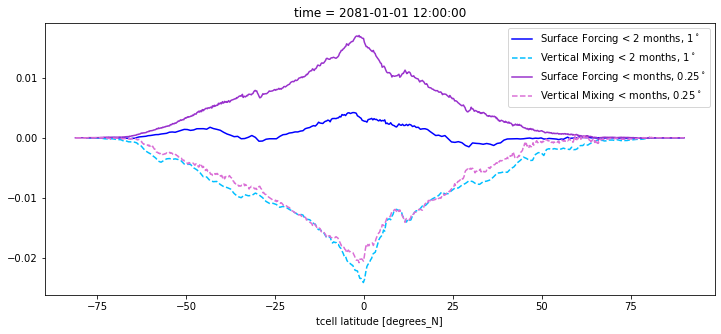

In [25]:
plt.figure(figsize = (12,5))
(SF_diurnal_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = 'Surface Forcing < 2 months, 1$^\circ$', color = 'blue',linestyle = '-')
(MX_diurnal_1.sum('grid_xt_ocean')/dy1/1.e15*dT1).sum('neutralrho_edges').plot(label = 'Vertical Mixing < 2 months, 1$^\circ$', color = 'deepskyblue',linestyle = '--')
(SF_diurnal_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'Surface Forcing < months, 0.25$^\circ$', color = 'darkorchid',linestyle = '-')
(MX_diurnal_025.sum('grid_xt_ocean')/dy/1.e15*dT).sum('neutralrho_edges').plot(label = 'Vertical Mixing < months, 0.25$^\circ$', color = 'orchid',linestyle = '--')
plt.legend()